# **EXPERIMENTO 01**

# **1. Preprocesamiento**
Para el preprocesamiento, se realizaron cuatro tareas básicas.

## **1.1 Carga y Organización del Dataset:**
El conjunto de datos, compuesto por imágenes de mariposas en formato **.png**, se cargó directamente desde el sistema de archivos, importandolo desde Kaggle (path = kagglehub.dataset_download("veeralakrishna/butterfly-dataset").
Para organizar las imágenes, se creó un DataFrame de Pandas. La etiqueta (clase) de cada imagen se extrajo del nombre del archivo, que seguía el formato de [ID_categoria][número_secuencial].png. Este método permitió la categorización automatizada de las imágenes.

In [2]:
!pip install pandas scikit-learn


In [3]:
# Hacemos la importación de las librerías necesarias
import os
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [4]:
# Movemos el archivo a la carpeta correcta
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Descargamos la última versión
path = kagglehub.dataset_download("veeralakrishna/butterfly-dataset")

print("Ruta para los archivos del dataset:", path)

Ruta para los archivos del dataset: /kaggle/input/butterfly-dataset


In [6]:
# Definimos la ruta local
ruta_base = '/kaggle/input/butterfly-dataset/leedsbutterfly/'
ruta_imagenes = os.path.join(ruta_base, 'images')

In [7]:
# Obtenemos todos los archivos en el directorio de imágenes
print("Contenido inicial del directorio de imágenes:")
print(os.listdir(ruta_imagenes))
print("-" * 50)

Contenido inicial del directorio de imágenes:
['0020155.png', '0090177.png', '0090201.png', '0100038.png', '0070055.png', '0060059.png', '0070068.png', '0070044.png', '0090114.png', '0070099.png', '0050049.png', '0020112.png', '0100023.png', '0040082.png', '0100018.png', '0040034.png', '0060180.png', '0060030.png', '0050041.png', '0050007.png', '0050086.png', '0040057.png', '0030056.png', '0070059.png', '0050059.png', '0080030.png', '0010054.png', '0060185.png', '0020050.png', '0020092.png', '0060092.png', '0010078.png', '0050011.png', '0020186.png', '0050072.png', '0060188.png', '0090060.png', '0070027.png', '0060157.png', '0060186.png', '0060179.png', '0020144.png', '0100126.png', '0070003.png', '0100137.png', '0070016.png', '0020167.png', '0010017.png', '0070088.png', '0030057.png', '0050006.png', '0010063.png', '0090024.png', '0090116.png', '0090126.png', '0050050.png', '0070030.png', '0040015.png', '0050080.png', '0100050.png', '0020120.png', '0080059.png', '0080033.png', '0070102

## **1.2 Filtrado de archivos**
Para asegurar la integridad del dataset y evitar errores, se implementó un filtro. Se procesaron únicamente los archivos que terminaban con la extensión **.png**, **descartando cualquier otro tipo de archivo** o directorio que no correspondiera a una imagen del dataset.

In [8]:
lista_archivos_filtrada = [f for f in os.listdir(ruta_imagenes) if f.endswith('.png')]

In [9]:
# Aquí imprimimos la lista de archivos que realmente se van a procesar
print("Archivos filtrados para el procesamiento:")
# Imprimimos solo los primeros 10
print(lista_archivos_filtrada[:10])
print(f"\nTotal de archivos a procesar: {len(lista_archivos_filtrada)}")
print("-" * 50)

Archivos filtrados para el procesamiento:
['0020155.png', '0090177.png', '0090201.png', '0100038.png', '0070055.png', '0060059.png', '0070068.png', '0070044.png', '0090114.png', '0070099.png']

Total de archivos a procesar: 832
--------------------------------------------------


## **1.3 División del Dataset**
El DataFrame se dividió en tres subconjuntos disjuntos: entrenamiento (80%), validación (10%) y prueba (10%). La división se realizó de manera estratificada (stratify), garantizando que la proporción de imágenes de cada clase de mariposa fuera la misma en los tres conjuntos. Esto es crucial para que el modelo se entrene y evalúe con una distribución de clases representativa y balanceada, evitando sesgos.

In [10]:
if not lista_archivos_filtrada:
    print("Error: No se encontraron archivos de imágenes con formato .png")
else:
    # Creamos el DataFrame con los archivos válidos
    df_imagenes = pd.DataFrame({'filepath': [os.path.join(ruta_imagenes, f) for f in lista_archivos_filtrada]})

    # Extraemos la etiqueta tomando los primeros 3 caracteres
    df_imagenes['label'] = df_imagenes['filepath'].apply(lambda x: os.path.basename(x)[:3])

    # Verificamos que se creó el DataFrame correctamente
    print("Primeras 5 filas del DataFrame con las etiquetas extraídas:")
    print(df_imagenes.head())
    print("-" * 50)

    # Imprimimos el conteo de imágenes por clase para verificar que todo está bien
    print("Conteo de imágenes por clase:")
    print(df_imagenes['label'].value_counts())
    print("-" * 50)

    # Aquí dividimos los datos en conjuntos de entrenamiento, validación y prueba
    train_df, temp_df = train_test_split(df_imagenes, test_size=0.2, random_state=42, stratify=df_imagenes['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

    # Hacemos una verificación final
    print("Verificación de los tamaños de los conjuntos de datos:")
    print(f"Número de imágenes para entrenamiento: {len(train_df)}")
    print(f"Número de imágenes para validación: {len(val_df)}")
    print(f"Número de imágenes para prueba: {len(test_df)}")
    print("-" * 50)

Primeras 5 filas del DataFrame con las etiquetas extraídas:
                                            filepath label
0  /kaggle/input/butterfly-dataset/leedsbutterfly...   002
1  /kaggle/input/butterfly-dataset/leedsbutterfly...   009
2  /kaggle/input/butterfly-dataset/leedsbutterfly...   009
3  /kaggle/input/butterfly-dataset/leedsbutterfly...   010
4  /kaggle/input/butterfly-dataset/leedsbutterfly...   007
--------------------------------------------------
Conteo de imágenes por clase:
label
006    100
002     93
009     90
004     90
007     89
005     88
010     84
001     82
003     61
008     55
Name: count, dtype: int64
--------------------------------------------------
Verificación de los tamaños de los conjuntos de datos:
Número de imágenes para entrenamiento: 665
Número de imágenes para validación: 83
Número de imágenes para prueba: 84
--------------------------------------------------


## **1.4 Normalización**
En esta etapa ajustaremos los valores de los píxeles de las imágenes para que se encuentren en un rango estándar, en este caso será al rango **[0,1]**.  Los modelos de aprendizaje profundo, como el **Multilayer Perceptron (MLP)** que usarán, se entrenan más rápido y de manera más estable cuando los datos de entrada están en un rango pequeño y consistente. Las imágenes tienen valores de píxeles que van de **0 a 255**, que es un rango bastante grande. Reducir esto ayuda al modelo a aprender de forma más eficiente.

Para esta etapa, necesitamos usar librerías de procesamiento de imágenes. Las más comunes son PIL (Pillow) o OpenCV. En este proyecto, como el siguiente paso es usar **PyTorch**, el método más conveniente es usar las transformaciones de la librería **torchvision**.

La intención es cargar cada imagen, convertirla en un tensor de PyTorch, normalizar los valores de los píxeles, redimensionar la imagen a un tamaño fijo, que podría ser 64x64 píxeles, ya que las entradas de la red neuronal deben tener el mismo tamaño.

In [11]:
# Definimos las transformaciones para el conjunto de entrenamiento, cabe señalar que el incremento de datos solo se aplica al entrenamiento
transformaciones_entrenamiento = transforms.Compose([
    transforms.Resize((64, 64)),
    # Volteamos la imagen horizontalmente
    # transforms.RandomHorizontalFlip(p=0.5),
    # Rotamos la imagen en un ángulo aleatorio
    # transforms.RandomRotation(degrees=15),
    transforms.ToTensor()
])

# Definimos las transformaciones para los conjuntos de validación y prueba, no se usa aumentación en estos conjuntos
transformaciones_validacion_prueba = transforms.Compose([
    # Redimensionamos las imágenes a un tamaño fijo.
    transforms.Resize((64, 64)),
    # Convertimos la imagen a un tensor de PyTorch.
    transforms.ToTensor(),
])

In [12]:
# Para verificación, hace el uso de una sola imagen:
ruta_de_ejemplo = train_df['filepath'].iloc[0]

# Abrimos la imagen usando la librería PIL (Pillow)
imagen_original = Image.open(ruta_de_ejemplo)

# Aplicamos la cadena de transformaciones a la imagen.
imagen_normalizada = transformaciones_validacion_prueba(imagen_original)

# Verificamos la forma del tensor (Canales x Alto x Ancho)
print(f"Forma del tensor normalizado: {imagen_normalizada.shape}")

# Imprimimos una muestra de los valores de píxeles
print(f"Valores de píxeles normalizados (muestra): \n{imagen_normalizada[0, 0, :5]}")

Forma del tensor normalizado: torch.Size([3, 64, 64])
Valores de píxeles normalizados (muestra): 
tensor([0.1725, 0.1804, 0.1686, 0.1686, 0.1412])


El resultado **torch.Size([3, 64, 64])** es muy importante. Nos dice que, para el ejemplo de la primera imagen, el tensor tiene tres dimensiones:

*   **3:** Esto representa los canales de color (Rojo, Verde y Azul - RGB).

*   **64:** Esto es la altura de la imagen en píxeles.

*   **64:** Esto es la anchura de la imagen en píxeles.

El orden de las dimensiones es [canales, altura, anchura], que es el formato estándar de PyTorch para trabajar con imágenes. La segunda parte del resultado, **tensor([0.1725, 0.1804, 0.1686, 0.1686, 0.1412])**, muestra que los valores de los píxeles ya no están en el rango de 0 a 255, sino de 0 a 1. Esto confirma que la normalización se ha realizado correctamente.

Ahora que sabes que la normalización funciona para una sola imagen, el siguiente paso es **aplicarla a todo el conjunto de datos de entrenamiento**, validación y prueba. Esto se hace con una herramienta del mismo PyTorch llamada DataLoader que automatiza este proceso. Como se ve acontinuación, **se crean los DataLoaders para cada uno de tus conjuntos de datos** (train_df, val_df, y test_df).

### **1.4.1 Crear una Clase de Dataset Personalizada**

In [13]:
# Definimos la clase personalizada del dataset
class ButterflyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.clases = sorted(list(self.dataframe['label'].unique()))
        self.clase_a_indice = {clase: i for i, clase in enumerate(self.clases)}

    def __len__(self):
        # Esto entrega el número total de imágenes en el dataset
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Obtenemos la ruta y la etiqueta de la fila actual
        ruta_imagen = self.dataframe.iloc[idx]['filepath']
        etiqueta_str = self.dataframe.iloc[idx]['label']

        # Cargamos la imagen desde la ruta
        imagen = Image.open(ruta_imagen)

        # Convertimos la etiqueta de texto (ej. '001') a un índice numérico
        etiqueta_idx = self.clase_a_indice[etiqueta_str]

        # Aplicamos la transformación a la imagen
        if self.transform:
            imagen = self.transform(imagen)

        # Aqui devolvemos la imagen como un tensor y la etiqueta como un tensor de tipo long
        return imagen, torch.tensor(etiqueta_idx, dtype=torch.long)

### **1.4.2 Crear los DataLoaders**

In [14]:
# Creamos las instancias del dataset con las transformaciones correctas
dataset_train = ButterflyDataset(train_df, transform=transformaciones_entrenamiento)
dataset_val = ButterflyDataset(val_df, transform=transformaciones_validacion_prueba)
dataset_test = ButterflyDataset(test_df, transform=transformaciones_validacion_prueba)

# Definimos el tamaño del lote
batch_size = 32

# Creamos los DataLoaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# **2. Creación del Modelo MLP**

Aquí tendremos una Capa de Entrada (Input Layer) que recibirá el tensor de la imagen. Luego pasará por las Capas Ocultas (Hidden Layers) donde las neuronas procesan la información de la capa anterior, aplicando cálculos y activaciones. Cuantas más capas ocultas y más neuronas, más compleja se hace la red. Por último, tendremos una Capa de Salida (Output Layer), la cual genera la predicción final. Para nuestra tarea de clasificación de 10 mariposas, esta capa tendrá 10 neuronas, una para cada tipo de mariposa. A continuación definiremos esta estructura en PyTorch. Usaremos la clase **torch.nn.Module**, que es el pilar para construir redes neuronales en **PyTorch**.

In [15]:
dropout_rate = 0.0

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, dropout_rate=dropout_rate):
        super(MLP, self).__init__()

        # Definimos la arquitectura de la red en el constructor
        self.layers = nn.ModuleList()

        # Esta es la capa de entrada
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))

        # Estas son las capas ocultas
        for i in range(len(hidden_layers) - 1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))

        # Se añade la capa de dropout después de cada capa lineal (excepto la de salida)
        self.dropout = nn.Dropout(p=dropout_rate)

        # Creamos la capa de salida como un módulo independiente
        self.output_layer = nn.Linear(hidden_layers[-1], num_classes)

    def forward(self, x):
        # Aplanamos el tensor de la imagen de 3D a 1D, lo cual es necesario porque el MLP procesa datos planos, no imágenes 3D
        x = x.view(x.size(0), -1)

        # Pasamos los datos a través de cada capa, aplicando la función de activación ReLU
        for layer in self.layers:
            x = F.relu(layer(x))
            # Aplicamos dropout después de la activación
            x = self.dropout(x)

        # Pasamos los datos a través de la última capa sin activación, y la función de pérdida 'CrossEntropyLoss' de PyTorch ya incluye la función softmax
        x = self.output_layer(x)
        return x

**__init__:** En este método, definimos las capas de la red. nn.Linear crea una capa totalmente conectada, lo que significa que cada neurona en una capa está conectada a cada neurona en la siguiente. nn.ModuleList es una lista para almacenar estas capas de manera que PyTorch las reconozca como parte del modelo.

**forward:** Este método es la parte más importante. Define cómo fluyen los datos (el tensor x) desde la entrada hasta la salida.

**x.view(x.size(0), -1):** Este comando aplana la imagen. Un tensor de imagen de [32, 3, 64, 64] (lote, canales, alto, ancho) se convierte en [32, 12288] (lote, total de píxeles), lo que prepara los datos para las capas lineales del MLP.

**F.relu(layer(x)):** Aquí es donde se aplican la mayoría de los cálculos. layer(x) realiza el cálculo lineal, y F.relu aplica la función de activación ReLU. Las funciones de activación añaden no-linealidad, permitiendo al modelo aprender patrones complejos.

**self.layers[-1](x):** La última capa no tiene una función de activación porque la función de pérdida (CrossEntropyLoss) que usarás más adelante ya se encarga de aplicar la función de activación final (softmax).

# **3. Fase de entrenamiento**

Ahora que tenemos la estructura del MLP (MLP class) y los datos listos en DataLoaders, el siguiente paso es la fase de entrenamiento. Aquí es donde el modelo "aprende" a clasificar las imágenes.

Este proceso implica tres elementos clave:

1.   Función de Pérdida (Loss Function): Mide qué tan mal está el modelo en sus predicciones. Si la predicción es muy diferente de la etiqueta real, la pérdida es alta. Si es similar, la pérdida es baja.

2.   Optimizador (Optimizer): Es el algoritmo que usa la pérdida para ajustar los pesos del modelo. Su objetivo es encontrar los mejores pesos para que la pérdida sea lo más baja posible.

3.   Bucle de Entrenamiento (Training Loop): Es un ciclo que repite el proceso de pasar los datos por la red, calcular la pérdida y ajustar los pesos. Esto se hace por un número determinado de épocas.

## **3.1 Configuración del entrenamiento**
Primero, necesitamos crear instancias del modelo, la función de pérdida y el optimizador.
*   **nn.CrossEntropyLoss():** Esta función de pérdida es perfecta para tu problema. Combina la función Softmax (que convierte los resultados del modelo en probabilidades) y la pérdida de entropía cruzada.

*   **torch.optim.Adam:** Es uno de los optimizadores más eficientes y fáciles de usar. Es el motor que ajustará los pesos de tu red.

In [16]:
# Definimos los parámetros del modelo y del entrenamiento
num_clases = len(dataset_train.clases)
input_size = 3 * 64 * 64
hidden_layers = [128, 64]
lr = 0.001

# Cremaos una instancia del modelo
model = MLP(input_size=input_size, hidden_layers=hidden_layers, num_classes=num_clases)

# Definimos la función de pérdida., CrossEntropyLoss es la función estándar para la clasificación multiclase
criterion = nn.CrossEntropyLoss()

# Definimos el optimizador Adam es un optimizador popular y eficiente.
# El 'lr' (learning rate) controla el tamaño de los ajustes que hace el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Movemos el modelo a la GPU si en caso este está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Modelo y optimizador configurados en el dispositivo: {device}")

Modelo y optimizador configurados en el dispositivo: cpu


## **3.2 Bucle de Entrenamiento y Validación**
Ahora, vamos a crear el bucle que hará que el modelo aprenda. Esto se realiza en dos etapas por cada época:

*   **Entrenamiento**: El modelo ve los datos de entrenamiento y ajusta sus pesos.

*   **Validación**: El modelo ve los datos de validación para evaluar su rendimiento en datos que no ha visto. Esto es clave para evitar el sobreajuste (overfitting).

**Análisis del Bucle:**

*   **optimizer.zero_grad():** Borra los gradientes de la iteración anterior para evitar que se acumulen.

*   **loss.backward():** Calcula los gradientes de la pérdida con respecto a todos los parámetros del modelo. Esto es el "autograd" en acción.

*   **optimizer.step():** Usa los gradientes calculados para actualizar los pesos del modelo.

Este es el proceso completo de entrenamiento. Al final, se tendrá los modelos entrenados y los datos para graficar la pérdida y la precisión a lo largo de las épocas.

In [17]:
# Definimos el de veces que el modelo verá todo el dataset, osea las épocas
num_epochs = 50

# Creamos las listas para guardar las métricas de entrenamiento y validación
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Definimos el bucle de Entrenamiento
    model.train() # Configuramos el modelo en modo de entrenamiento
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in dataloader_train:
        images, labels = images.to(device), labels.to(device)
        # Reseteamos a cero los gradientes acumulados
        optimizer.zero_grad()
        # Pasamos los datos por la red
        outputs = model(images)
        # Calculamos la pérdida
        loss = criterion(outputs, labels)
        # Calculamos los gradientes (Paso hacia atrás)
        loss.backward()
        # Ajustamos los pesos del modelo
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        # Calculamos la precisión
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(dataloader_train.dataset)
    train_accuracy = 100 * correct_train / total_train

    # Definimos el bucle de Validación
    model.eval() # Configuramos el modelo en modo de evaluación
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
    # Deshabilitamos el cálculo de gradientes
        for images, labels in dataloader_val:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_val = criterion(outputs, labels)
            running_val_loss += loss_val.item() * images.size(0)

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    avg_val_loss = running_val_loss / len(dataloader_val.dataset)
    val_accuracy = 100 * correct_val / total_val

    # Guardamos las métricas
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Imprimimos el progreso
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida de Entrenamiento: {avg_train_loss:.4f}, Precisión de Entrenamiento: {train_accuracy:.2f}%, Pérdida de Validación: {avg_val_loss:.4f}, Precisión de Validación: {val_accuracy:.2f}%")

Época [1/50], Pérdida de Entrenamiento: 2.3493, Precisión de Entrenamiento: 13.53%, Pérdida de Validación: 2.1928, Precisión de Validación: 19.28%
Época [2/50], Pérdida de Entrenamiento: 2.1216, Precisión de Entrenamiento: 22.71%, Pérdida de Validación: 2.0587, Precisión de Validación: 24.10%
Época [3/50], Pérdida de Entrenamiento: 1.9995, Precisión de Entrenamiento: 27.52%, Pérdida de Validación: 1.9470, Precisión de Validación: 27.71%
Época [4/50], Pérdida de Entrenamiento: 1.8254, Precisión de Entrenamiento: 38.20%, Pérdida de Validación: 1.7711, Precisión de Validación: 34.94%
Época [5/50], Pérdida de Entrenamiento: 1.6664, Precisión de Entrenamiento: 43.31%, Pérdida de Validación: 1.6759, Precisión de Validación: 36.14%
Época [6/50], Pérdida de Entrenamiento: 1.5607, Precisión de Entrenamiento: 45.71%, Pérdida de Validación: 1.9344, Precisión de Validación: 32.53%
Época [7/50], Pérdida de Entrenamiento: 1.4777, Precisión de Entrenamiento: 50.83%, Pérdida de Validación: 1.5638, Pre

Época de máx. validación: 30
Máx. validación (%): 59.0
Entrenamiento en máx. validación (%): 96.4
Época de máx. entrenamiento: 43
Máx. entrenamiento (%): 100.0
Validación en máx. entrenamiento (%): 59.0


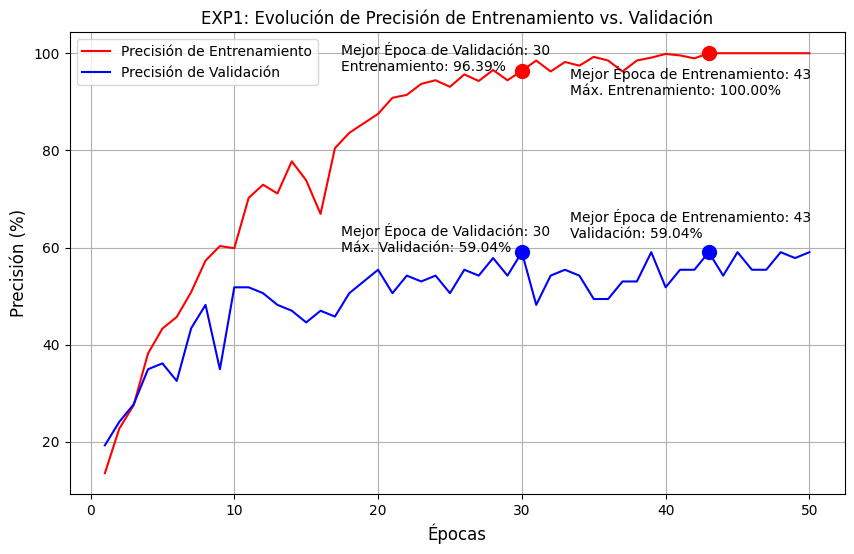

In [26]:
# Encontramos la época y el valor de la precisión de validación máxima
best_epoch_index_val = np.argmax(val_accuracies)
best_epoch_val = best_epoch_index_val + 1
max_val_accuracy = val_accuracies[best_epoch_index_val]

# Encontramos la época y el valor de la precisión del entrenamiento máximo
best_epoch_index_train = np.argmax(train_accuracies)
best_epoch_train = best_epoch_index_train + 1
max_train_accuracy = train_accuracies[best_epoch_index_train]

# Encontramos la precisión de entrenamiento en la mejor validación
train_accuracy_at_best_epoch_val = train_accuracies[best_epoch_index_val]
val_accuracy_at_best_epoch_train = val_accuracies[best_epoch_index_train]

# Imprimimos
print(f"Época de máx. validación: {best_epoch_val}")
print(f"Máx. validación (%): {max_val_accuracy:.1f}")
print(f"Entrenamiento en máx. validación (%): {train_accuracy_at_best_epoch_val:.1f}")
print(f"Época de máx. entrenamiento: {best_epoch_train}")
print(f"Máx. entrenamiento (%): {max_train_accuracy:.1f}")
print(f"Validación en máx. entrenamiento (%): {val_accuracy_at_best_epoch_train:.1f}")

# Creamos el gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, color='red', label='Precisión de Entrenamiento')
plt.plot(range(1, num_epochs + 1), val_accuracies, color='blue', label='Precisión de Validación')
plt.title('EXP1: Evolución de Precisión de Entrenamiento vs. Validación', fontsize=12)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.grid(True)
plt.legend()

# Marcamos el punto de la máxima precisión de validación (mejor época)
plt.plot(best_epoch_val, max_val_accuracy, 'bo', markersize=10)

# Marcamos el punto de la precisión de entrenamiento en la mejor época de entrenavalidación
plt.plot(best_epoch_val, train_accuracy_at_best_epoch_val, 'ro', markersize=10)

# Marcamos el punto de la máxima precisión de entrenamiento
plt.plot(best_epoch_train, max_train_accuracy, 'ro', markersize=10)

# Marcamos el punto de la precisión de validación en la mejor época de entrenamiento
plt.plot(best_epoch_train, val_accuracy_at_best_epoch_train, 'bo', markersize=10)

# Agregamos la etiqueta de datos para el punto de validación máximo.
plt.annotate(
    f'Mejor Época de Validación: {best_epoch_val}\nMáx. Validación: {max_val_accuracy:.2f}%',
    xy=(best_epoch_val, max_val_accuracy),
    xytext=(-130, 0),
    textcoords='offset points',
)
# Agregamos la etiqueta de datos para el punto de entrenamiento.
plt.annotate(
    f'Mejor Época de Validación: {best_epoch_val}\nEntrenamiento: {train_accuracy_at_best_epoch_val:.2f}%',
    xy=(best_epoch_val, train_accuracy_at_best_epoch_val),
    xytext=(-130, 0),
    textcoords='offset points',
)

# Agregamos la etiqueta de datos para el punto de entrenamiento máximo.
plt.annotate(
    f'Mejor Época de Entrenamiento: {best_epoch_train}\nMáx. Entrenamiento: {max_train_accuracy:.2f}%',
    xy=(best_epoch_train, max_train_accuracy),
    xytext=(-100, -30),
    textcoords='offset points',
)
# Agregamos la etiqueta de datos para el punto de validación.
plt.annotate(
    f'Mejor Época de Entrenamiento: {best_epoch_train}\nValidación: {val_accuracy_at_best_epoch_train:.2f}%',
    xy=(best_epoch_train, val_accuracy_at_best_epoch_train),
    xytext=(-100, 10),
    textcoords='offset points',
)

plt.show()

# **4. Fase de evaluación del modelo**
Una vez que el modelo ha terminado de entrenar (con las épocas suficientes), el último paso es evaluarlo usando el conjunto de prueba. A diferencia de los conjuntos de entrenamiento y validación, el modelo nunca ha visto estos datos, por lo que la evaluación final nos dará una idea aterrizada de su rendimiento en el mundo real.

Para esto, calcularemos las métricas siguientes: la matriz de confusión, el precision, el recall y el F1-score.

In [19]:
# Asegúramos de que el modelo esté en modo de evaluación
model.eval()

# Listamos para almacenar las predicciones y las etiquetas reales
y_true = []
y_pred = []

# Desactivamos el cálculo de gradientes para la evaluación
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculamos las métricas de precisión, recall y F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Generamos la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

## **4.1 Visualización (limpio)**

Reporte de Clasificación con Conteo:

  Clase Precisión Recall F1-score  Conteo
0   001      0.56   0.62     0.59      82
1   002      0.78   0.70     0.74      93
2   003      0.20   0.17     0.18      61
3   004      0.56   0.56     0.56      90
4   005      0.44   0.44     0.44      88
5   006      0.77   1.00     0.87     100
6   007      0.57   0.44     0.50      89
7   008      0.67   0.80     0.73      55
8   009      0.83   0.56     0.67      90
9   010      0.45   0.56     0.50      84


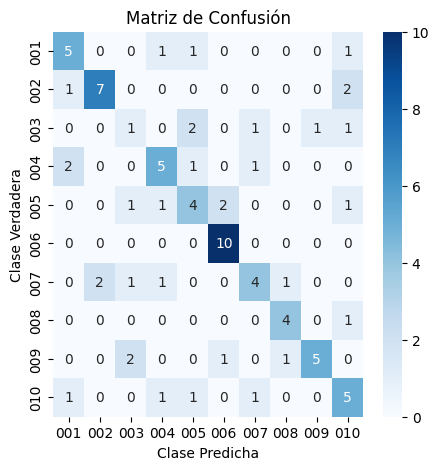

In [20]:
# Mapeamos los índices a los nombres de las clases (IDs)
clases_dict = {i: clase for i, clase in enumerate(dataset_test.clases)}
clases_a_mostrar = [clases_dict[i] for i in range(len(clases_dict))]

# Obtenemos los conteos de imágenes y los convierte a un diccionario para fácil acceso
conteo_clases = df_imagenes['label'].value_counts().to_dict()

# Ordenamos el diccionario de conteos según el orden de las clases a mostrar, para que los datos estén alineados correctamente
conteo_ordenado = [conteo_clases.get(clase, 0) for clase in clases_a_mostrar]

# Creamos el diccionario de datos con todas las columnas
reporte_data = {
    'Clase': clases_a_mostrar,
    'Precisión': [f"{p:.2f}" for p in precision],
    'Recall': [f"{r:.2f}" for r in recall],
    'F1-score': [f"{f:.2f}" for f in f1_score],
    'Conteo': conteo_ordenado
}

# Creamos el DataFrame final a partir de este único diccionario
df_reporte_final = pd.DataFrame(reporte_data)

# Imprimimos el reporte de clasificación actualizado
print("Reporte de Clasificación con Conteo:\n")
print(df_reporte_final)

# Para visualizar la matriz de confusión
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases_a_mostrar, yticklabels=clases_a_mostrar)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión')
plt.show()